# GI Prediction Category Testing

This notebook tests our GI prediction system across different recipe categories:
1. Simple recipes
2. High GI recipes
3. Low GI recipes

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from agents.gi_agent import GIAnalysisAgent
from agents.gi_grader_agent import GIGraderAgent
from test_data.simple.simple_recipes import SIMPLE_RECIPES
from test_data.high_gi.high_gi_recipes import HIGH_GI_RECIPES
from test_data.low_gi.low_gi_recipes import LOW_GI_RECIPES
import json
from typing import List, Dict, Any
from datetime import datetime
import os

## Setup Results Directory

In [2]:
# Create timestamp for this test run
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
results_dir = f'test_results/{timestamp}'
plots_dir = f'{results_dir}/plots'
data_dir = f'{results_dir}/data'

# Create directories if they don't exist
os.makedirs(plots_dir, exist_ok=True)
os.makedirs(data_dir, exist_ok=True)

print(f"Results will be saved in: {results_dir}")

Results will be saved in: test_results/20250518_094518


## Initialize Agents

In [3]:
# Initialize agents
gi_agent = GIAnalysisAgent()
grader_agent = GIGraderAgent()

Successfully loaded food data with 5000 entries


## Test Function

In [4]:
def test_category(recipes: List[Dict[str, Any]], category_name: str) -> pd.DataFrame:
    """Test a category of recipes and return results"""
    results = []
    
    for recipe in recipes:
        # Get our prediction
        our_result = gi_agent.process([recipe])
        if 'error' in our_result:
            print(f"Error processing {recipe['title']}: {our_result['error']}")
            continue
            
        our_prediction = our_result['glycemic_load']
        
        # Get expert grading
        grade_result = grader_agent.grade_prediction(recipe, our_prediction)
        
        # Store results
        results.append({
            'recipe': recipe['title'],
            'category': category_name,
            'our_prediction': our_prediction,
            'expert_assessment': grade_result['assessed_gi'],
            'prediction_difference': grade_result['prediction_difference']
        })
    
    return pd.DataFrame(results)

## Run Tests

In [5]:
# Test each category
simple_results = test_category(SIMPLE_RECIPES, "Simple")
high_gi_results = test_category(HIGH_GI_RECIPES, "High GI")
low_gi_results = test_category(LOW_GI_RECIPES, "Low GI")

# Combine results
all_results = pd.concat([simple_results, high_gi_results, low_gi_results])
all_results

Ingredient: brown rice
GI: 50.0, Carbs: 77.0g/100g, Quantity: 240.0g
GL contribution: 92.40
Ingredient: steamed vegetables
GI: 50.0, Carbs: 5.0g/100g, Quantity: 240.0g
GL contribution: 6.00
Ingredient: olive oil
GI: 0.0, Carbs: 0.0g/100g, Quantity: 15.0g
GL contribution: 0.00
Ingredient: soy sauce
GI: 15.0, Carbs: 4.7g/100g, Quantity: 5.0g
GL contribution: 0.04
Ingredient: red lentils
GI: 21.0, Carbs: 60.0g/100g, Quantity: 240.0g
GL contribution: 30.24
Ingredient: onion
GI: 10.0, Carbs: 9.0g/100g, Quantity: 1.0g
GL contribution: 0.01
Ingredient: carrots
GI: 41.0, Carbs: 9.0g/100g, Quantity: 2.0g
GL contribution: 0.07
Ingredient: vegetable broth
GI: 50.0, Carbs: 1.0g/100g, Quantity: 960.0g
GL contribution: 4.80
Ingredient: cumin
GI: 50.0, Carbs: 44.0g/100g, Quantity: 5.0g
GL contribution: 1.10
Ingredient: quinoa
GI: 53.0, Carbs: 21.0g/100g, Quantity: 240.0g
GL contribution: 26.71
Ingredient: cucumber
GI: 15.0, Carbs: 3.6g/100g, Quantity: 1.0g
GL contribution: 0.01
Ingredient: tomatoes
G

,recipe,category,our_prediction,expert_assessment,prediction_difference
0,Basic Brown Rice Bowl,Simple,98.43525,50.0,48.43525
1,Simple Lentil Soup,Simple,36.22280,30.0,6.22280
2,Basic Quinoa Salad,Simple,26.74710,53.0,26.25290
3,Simple Tofu Stir Fry,Simple,105.15000,50.0,55.15000
4,Basic Bean Bowl,Simple,112.21350,40.0,72.21350
0,White Rice and Sweet Potato Bowl,High GI,290.83644,65.0,225.83644
1,Pasta with White Sauce,High GI,209.88000,60.0,149.88000
2,Mashed Potatoes with Gravy,High GI,16.47000,70.0,53.53000
3,White Bread Sandwich,High GI,1.53200,70.0,68.46800
4,Breakfast Cereal Bowl,High GI,350.88930,75.0,275.88930


## Visualize Results

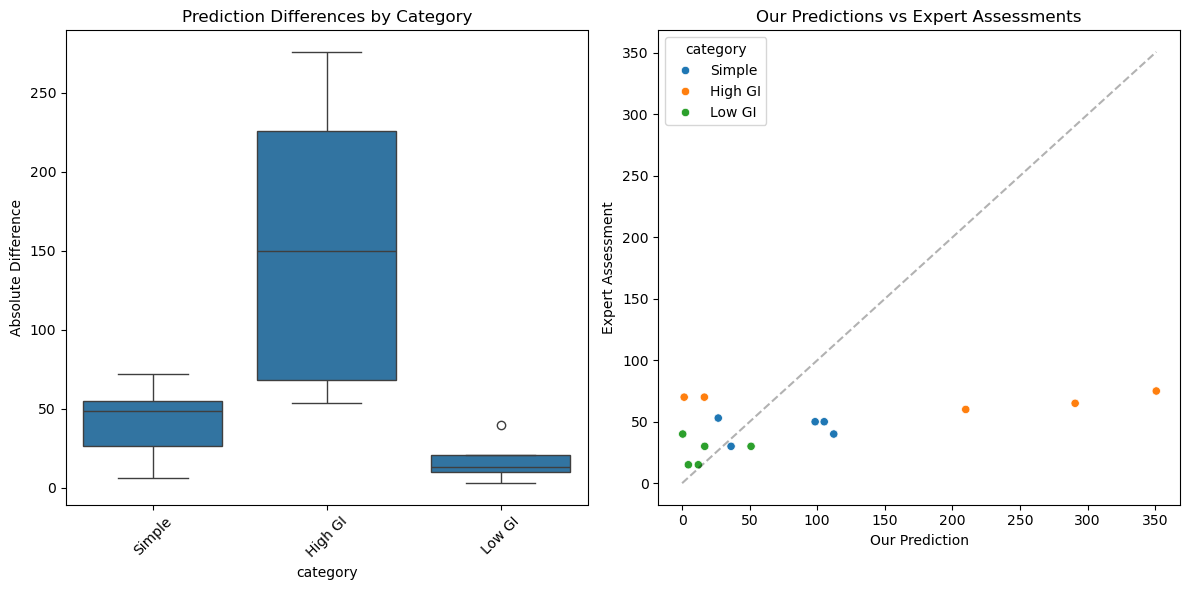

In [6]:
plt.figure(figsize=(12, 6))

# Box plot of prediction differences by category
plt.subplot(1, 2, 1)
sns.boxplot(x='category', y='prediction_difference', data=all_results)
plt.title('Prediction Differences by Category')
plt.xticks(rotation=45)
plt.ylabel('Absolute Difference')

# Scatter plot of our predictions vs expert assessments
plt.subplot(1, 2, 2)
sns.scatterplot(data=all_results, x='our_prediction', y='expert_assessment', hue='category')
plt.title('Our Predictions vs Expert Assessments')
plt.xlabel('Our Prediction')
plt.ylabel('Expert Assessment')

# Add diagonal line for perfect predictions
max_val = max(all_results['our_prediction'].max(), all_results['expert_assessment'].max())
plt.plot([0, max_val], [0, max_val], 'k--', alpha=0.3)

plt.tight_layout()
plt.savefig(f'{plots_dir}/gi_analysis.png')
plt.show()

## Analysis

In [7]:
print("\nOverall Statistics:")
print("=================")
print(f"Total recipes tested: {len(all_results)}")
print(f"Mean prediction difference: {all_results['prediction_difference'].mean():.2f}")
print(f"Standard deviation: {all_results['prediction_difference'].std():.2f}")
print(f"Max difference: {all_results['prediction_difference'].max():.2f}")
print(f"Min difference: {all_results['prediction_difference'].min():.2f}")

print("\nCategory-wise Statistics:")
print("======================")
for category in ['Simple', 'High GI', 'Low GI']:
    cat_results = all_results[all_results['category'] == category]
    print(f"\n{category}:")
    print(f"Number of recipes: {len(cat_results)}")
    print(f"Mean difference: {cat_results['prediction_difference'].mean():.2f}")
    print(f"Standard deviation: {cat_results['prediction_difference'].std():.2f}")


Overall Statistics:
Total recipes tested: 15
Mean prediction difference: 71.27
Standard deviation: 82.19
Max difference: 275.89
Min difference: 2.98

Category-wise Statistics:

Simple:
Number of recipes: 5
Mean difference: 41.65
Standard deviation: 25.76

High GI:
Number of recipes: 5
Mean difference: 154.72
Standard deviation: 96.75

Low GI:
Number of recipes: 5
Mean difference: 17.44
Standard deviation: 13.95


## Export Results

In [8]:
# Save detailed results to CSV
all_results.to_csv(f'{data_dir}/gi_test_results.csv', index=False)

# Save summary statistics
summary_stats = {
    'overall': {
        'total_recipes': len(all_results),
        'mean_difference': all_results['prediction_difference'].mean(),
        'std_difference': all_results['prediction_difference'].std(),
        'max_difference': all_results['prediction_difference'].max(),
        'min_difference': all_results['prediction_difference'].min()
    },
    'by_category': {
        category: {
            'count': len(all_results[all_results['category'] == category]),
            'mean_difference': all_results[all_results['category'] == category]['prediction_difference'].mean(),
            'std_difference': all_results[all_results['category'] == category]['prediction_difference'].std()
        }
        for category in ['Simple', 'High GI', 'Low GI']
    }
}

with open(f'{data_dir}/summary_stats.json', 'w') as f:
    json.dump(summary_stats, f, indent=4)

print(f"\nResults have been saved to {results_dir}")


Results have been saved to test_results/20250518_094518
